## Imports

In [1]:
# import plaidml.keras
# plaidml.keras.install_backend()
import wandb
import os
import multiprocessing
import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score, HammingLoss
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

import keras
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
np.set_printoptions(suppress=True)
np.set_printoptions(precision=6)

Using TensorFlow backend.


### Test with Simple CNN and Data Loader 

In [2]:
import boto3
import rasterio as rio
import numpy as np
import io

In [3]:
from data_loader import DataLoader

In [5]:
import wandb
from wandb.keras import WandbCallback 

wandb.init(project='project_canopy', sync_tensorboard=True)
config = wandb.config

wandb: Currently logged in as: margauxmforsythe (use `wandb login --relogin` to force relogin)


In [13]:
# Variables definition
config.batch_size = 20
config.learning_rate = 0.001
config.label_file_path_train="labels_full_train_v2.csv" # labels_1_4_train_v2
config.label_file_path_val="val_all.csv"
config.loss = SigmoidFocalCrossEntropy() # tf.keras.losses.BinaryCrossentropy(from_logits=False)
config.optimizer = keras.optimizers.Adam(config.learning_rate)
config.input_shape = (100,100,18)
config.numclasses=10

config.augment = True
config.flip_left_right=True
config.flip_up_down=False
config.rot90=False
config.transpose=False
config.enable_shuffle=True

print(f"batch size {config.batch_size}, learning_rate {config.learning_rate}, augment {config.augment}")

batch size 20, learning_rate 0.001, augment True


In [15]:
gen = DataLoader(label_file_path_train=config.label_file_path_train, # test labels_test_v1 TODO use s3 paths
                label_file_path_val=config.label_file_path_val, # or val_all
                bucket_name='canopy-production-ml',
                data_extension_type='.tif',
                training_data_shape=(100, 100, 18),
                augment=config.augment,
                s3_file_paths=False,
                flip_left_right=config.flip_left_right,
                flip_up_down=config.flip_up_down,
                rot90=config.rot90,
                transpose=config.transpose,
                enable_shuffle=config.enable_shuffle,
                training_data_batch_size=config.batch_size,
                enable_data_prefetch=True
                )


The file labels_full_train_v2.csv is missing positive labels for classes []
The file val_all.csv is missing positive labels for classes []
Data augmentation enabled: flip_up_down False, flip_left_right True, rot90 False
Training on 31544 images
Validation on 6794 images 


In [16]:
gen.class_weight_val

{0: 6.74051724137931,
 1: 0.8508161044613711,
 2: 3.23099173553719,
 3: 21.13243243243243,
 4: 0.1839764705882353,
 5: 1.7222466960352425,
 6: 3.522072072072072,
 7: 1.1618127786032688,
 8: 1.6707264957264958,
 9: 1.7851598173515981}

In [17]:
gen.class_weight_train

{0: 3.092068429237947,
 1: 0.5266754966887417,
 2: 1.736419213973799,
 3: 13.903496503496504,
 4: 0.4669328323156412,
 5: 1.1955502104630187,
 6: 2.269634703196347,
 7: 0.673737716028465,
 8: 0.6527248850952068,
 9: 1.4386396526772791}

In [7]:
# for image, label in iter(gen.training_dataset): # extract 1 batch at a time from the dataset
#     image = image.numpy()
#     label = label.numpy()
#     print(image.shape)    

#     fig = plt.figure(figsize=(22, 22))
#     for i in range(20): # display 20 first tiles from batch
#         ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
#         ax.imshow(image[i][:,:,0])
#         ax.set_title(f"Label: {label[i]}")
#     plt.show()
    
#     break

In [ ]:
# img, label = next(iter(gen.training_dataset))
# print(img[0]) # checking normalization 

In [9]:
# for image, label in iter(gen.training_dataset): # extract 1 batch at a time from the dataset
#     image = image.numpy()
#     label = label.numpy()
#     print(image.shape)    

#     fig = plt.figure(figsize=(22, 22))
#     for i in range(4): # display 4 first tiles from batch
#         ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
#         ax.imshow(image[i][:,:,0])
#         ax.set_title(f"Label: {label[i]}")
#     plt.show()



In [18]:
def plot_learningCurve(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
#   plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
#   plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Val'], loc='upper left')
  plt.show()

  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Val'], loc='upper left')
  plt.show()




## PREPRODUCTION Candidate: ResNet50 pretrained on ImageNet

### Build model

In [19]:
def define_model(numclasses,input_shape):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights='imagenet',
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='sigmoid')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
#     model = model.layers[-1].bias.assign([0.0]) # WIP getting an error ValueError: Cannot assign to variable dense_8/bias:0 due to variable shape (10,) and value shape (1,) are incompatible

#     model.summary()
    return model

In [20]:
random_id = random.randint(1,10001) 

model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
  filepath= f'checkpoints/checkpoint_loss_{random_id}.h5',
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

model_checkpoint_callback_recall = tf.keras.callbacks.ModelCheckpoint(
  filepath= f'checkpoints/checkpoint_recall_{random_id}.h5',
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_recall',
  mode='max',
  save_best_only=True)

model_checkpoint_callback_precision = tf.keras.callbacks.ModelCheckpoint(
  filepath= f'checkpoints/checkpoint_precision_{random_id}.h5',
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_precision',
  mode='max',
  save_best_only=True)

# reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
#   monitor='val_loss', factor=0.1, patience=5, verbose=1,
#   mode='min', min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_precision', mode='max', patience=20, verbose=1)

wandb_callback = WandbCallback()
callbacks_list = [model_checkpoint_callback_loss, model_checkpoint_callback_recall, early_stop, wandb_callback] #TODO re add reducelronplateau

model = define_model(config.numclasses, config.input_shape)

# loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # Computes the cross-entropy loss between true labels and predicted labels.
# Focal loss instead of class weights: https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
model.compile(loss=SigmoidFocalCrossEntropy(), # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
              optimizer=keras.optimizers.Adam(config.learning_rate),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy'), 
                       tf.keras.metrics.Precision(name='precision'), # Computes the precision of the predictions with respect to the labels.
                       tf.keras.metrics.Recall(name='recall'), # Computes the recall of the predictions with respect to the labels.
                       F1Score(num_classes=10, name="f1_score") # https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
                       ]
#               sample_weight_mode="temporal" # This argument is not supported when x is a dataset or a dataset iterator, instead pass sample weights as the third element of x.
             )



### Start training

In [ ]:
epochs = 10
history = model.fit(gen.training_dataset, validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list,
                    shuffle=True # whether to shuffle the training data before each epoch
                   ) 


Epoch 1/10
    382/Unknown - 709s 2s/step - loss: 0.6382 - accuracy: 0.8972 - precision: 0.7645 - recall: 0.2982 - f1_score: 0.2945

Evaluation

In [17]:
loss, accuracy, precision, recall, f1score = model.evaluate(gen.validation_dataset) 

19/19 [==============================] - 70s 4s/step - loss: 0.6243 - accuracy: 0.8702 - precision: 0.4325 - recall: 0.3271 - f1_score: 0.1097


In [18]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(), (1, 2, 0))
print(img_test.shape)
label_list = ['Habitation', 'ISL', 'Industrial_agriculture', 'Mining',
    'Rainforest', 'River', 'Roads', 'Savannah', 'Shifting_cultivation',
    'Water'
]

(100, 100, 18)


In [19]:
predictions = model.predict(np.array([img_test]))

threshold = 0.2
argsort_list = list(np.argsort(np.array(predictions[0])))
argsort_list.reverse()
pred_labels = []
for top_matches in argsort_list:
    if predictions[0][top_matches] > threshold:
        pred_labels.append(label_list[top_matches])

print("This chip was predicted to belong to these classes:")
print(pred_labels)


This chip was predicted to belong to these classes:
['Savannah']


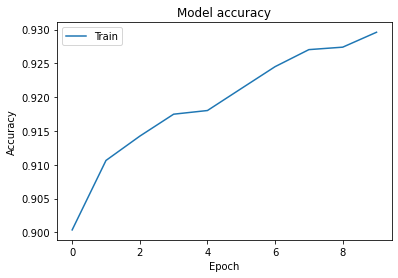

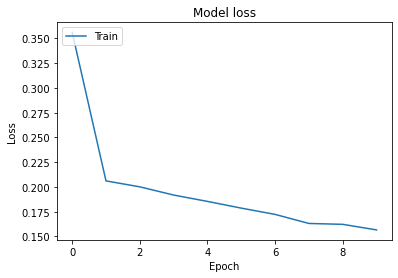

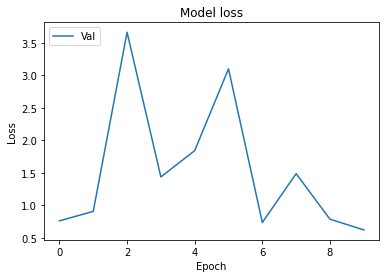

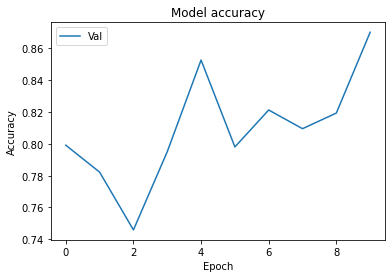

In [20]:
plot_learningCurve(history)

In [44]:
test_imgs = []
test_labels = []
number_imgs_limit = 200
nb_imgs = 0

# TODO: find a better way to do this, too slow
for image, label in iter(gen.validation_dataset): # TODO replace with test dataset 
    image = image.numpy()
    label = label.numpy()
#     print(image.shape)
    if image.shape[0] == config.batch_size:
        for b in range(config.batch_size):
            if nb_imgs < number_imgs_limit:
                test_imgs.append(image[b])
                test_labels.append(label[b])
                nb_imgs = nb_imgs + 1
            else:
                break
np.array(test_imgs).shape

(200, 100, 100, 18)

In [45]:
# test_labels

In [46]:
y_pred=model.predict(np.array(test_imgs))

In [47]:
y_true = np.array(test_labels)

In [48]:
y_true[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [50]:
y_pred[0]

array([0.009657, 0.64626 , 0.014202, 0.064673, 0.158961, 0.052127,
       0.073404, 0.072748, 0.049813, 0.000111], dtype=float32)

In [49]:
list(np.argsort(np.array(y_pred[0])))

[9, 0, 2, 8, 5, 3, 7, 6, 4, 1]

In [51]:
def compare_ytrue_ypred(y_true, y_pred,threshold=0.2):
    for idx in range(len(y_pred)):
        argsort_list = list(np.argsort(np.array(y_pred[idx])))
        argsort_list.reverse()
        true_classes_list = [ i for i in range(len(y_true[idx])) if y_true[idx][i] == 1 ]
        print(f"\n{idx}) True labels:")
        print([label_list[index] for index in true_classes_list])
        pred_labels = []
        for top_matches in argsort_list:
            if y_pred[idx][top_matches] > threshold:
                pred_labels.append(label_list[top_matches])
        print("Predicted labels:")
        print(pred_labels)
#         break
compare_ytrue_ypred(y_true, y_pred,threshold=0.2)


0) True labels:
['Rainforest']
Predicted labels:
['ISL']

1) True labels:
['Rainforest']
Predicted labels:
['ISL']

2) True labels:
['Rainforest']
Predicted labels:
['ISL']

3) True labels:
['Rainforest']
Predicted labels:
['ISL']

4) True labels:
['Rainforest', 'Roads']
Predicted labels:
['ISL']

5) True labels:
['Rainforest', 'Roads']
Predicted labels:
['ISL']

6) True labels:
['Rainforest', 'Roads']
Predicted labels:
['ISL']

7) True labels:
['Rainforest', 'Roads']
Predicted labels:
['ISL']

8) True labels:
['Rainforest']
Predicted labels:
['ISL']

9) True labels:
['Rainforest']
Predicted labels:
['ISL']

10) True labels:
['Rainforest']
Predicted labels:
['ISL']

11) True labels:
['Rainforest']
Predicted labels:
['Shifting_cultivation', 'Rainforest', 'Habitation']

12) True labels:
['Rainforest']
Predicted labels:
['Rainforest', 'Shifting_cultivation', 'River']

13) True labels:
['Rainforest']
Predicted labels:
['ISL']

14) True labels:
['Rainforest']
Predicted labels:
['ISL']

15)

Predicted labels:
['ISL']

188) True labels:
['Savannah']
Predicted labels:
['ISL']

189) True labels:
['Savannah']
Predicted labels:
['ISL', 'Rainforest']

190) True labels:
['Savannah']
Predicted labels:
['ISL']

191) True labels:
['ISL']
Predicted labels:
['ISL']

192) True labels:
['ISL']
Predicted labels:
['ISL']

193) True labels:
['ISL']
Predicted labels:
['ISL']

194) True labels:
['Roads']
Predicted labels:
['ISL']

195) True labels:
['ISL']
Predicted labels:
['ISL']

196) True labels:
['ISL']
Predicted labels:
['ISL']

197) True labels:
['ISL']
Predicted labels:
['ISL']

198) True labels:
['ISL', 'Savannah']
Predicted labels:
['ISL']

199) True labels:
['Savannah']
Predicted labels:
['ISL']


In [ ]:
# from sklearn.model_selection import GridSearchCV
# # Use scikit-learn to grid search 
# activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# weight_constraint=[1, 2, 3, 4, 5]
# neurons = [1, 5, 10, 15, 20, 25, 30]
# init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# ##############################################################
# # grid search epochs, batch size
# epochs = [1, 10] # add 50, 100, 150 etc
# batch_size = [1000, 5000] # add 5, 10, 20, 40, 60, 80, 100 etc
# param_grid = dict(epochs=epochs, batch_size=batch_size)
# ##############################################################
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(gen.training_dataset) 
# ##############################################################
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
# ##############################################################